In [ ]:
# Install depedencies for collab
!pip install spektral
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.3 MB/s 


In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file

# import rdkit stuff 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, BondType
IPythonConsole.ipython_useSVG=True 
# from tensorflow.keras.utils import Sequence
from glob import glob
import matplotlib.pyplot as plt 

# disable rdkit logger
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from multiprocessing import Pool

import spektral
from spektral.data import BatchLoader, Dataset, Graph
from spektral.layers import ECCConv, GlobalSumPool, GraphMasking, GlobalAttentionPool
from spektral.utils import label_to_one_hot, sparse
from spektral.utils.io import load_csv, load_sdf

import os
from tqdm import tqdm

In [2]:
################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 200  # Number of training epochs
batch_size = 64  # Batch size
n_out = 1

In [3]:
################################################################################
# Dataset Class
################################################################################


class logP(Dataset):
    """
    Spektral logP dataset class. 
    Downloads and encodes logP datasets used for training and testing of logP 
    predictor models in the paper titled "Predicting partition coefficients for 
    the SAMPL7 physical property challenge using the ClassicalGSG method" by 
    Donyapour Nazanin and Dickson Alex. https://doi.org/10.1007/s10822-021-00400-x
    
    The spektral dataset processing and encoding by: Oskar Klaja
    
    
    The datasets in SDF format are read and molecules are encoded as graphs. 
    Node features:
    - atom type (one-hot)
    - charge (value)
    - degree (value)
    - position (x, y, z)
    
    Edge features: single, double, triple or aromatic (one-hot encoded)
        
    
    dependencies: tensorflow, spektral, rdkit
    
    attributes: 
    - num_threads -- # of threads for sdf file reader
    - choose_file -- choose a specific version of a dataset, 
    defaults to DB1.sdf file
    
    returns --> instance of logP dataset (Spektral dataset)
    """
    
    def __init__(self, choose_file=None, num_threads=160, **kwargs):
        self.choose_file = choose_file
        self.num_threads = num_threads
        self.url = 'https://zenodo.org/record/4560967/files/datasets.zip?download=1'
        super().__init__(**kwargs)
        
    def read_sdf(self, path):
        mols = Chem.MultithreadedSDMolSupplier(path, numWriterThreads=self.num_threads)
        # mols = Chem.SDMolSupplier(path)
        res = [m for m in mols]
        return res
        
    def download(self):
        get_file(
            "datasets.zip",
            self.url,
            extract=True,
            cache_dir=self.path,
            cache_subdir=self.path,
        )
        os.remove(os.path.join(self.path, "datasets.zip"))
        
    def mol_to_adj(self, mol):
        BOND_TYPES = [0, 1, 2, 3]
        row, col, edge_features = [], [], []

        for bond in mol:
            start, end = bond["start_atom"], bond["end_atom"]
            row += [start, end]
            col += [end, start]
            edge_features += [bond["type"]] * 2

        a, e = sparse.edge_index_to_matrix(
            edge_index=np.array((row, col)).T,
            edge_weight=np.ones_like(row),
            edge_features=  label_to_one_hot(edge_features, BOND_TYPES),  # np.eye(len(BOND_TYPES))[] 
        )

        return a, e
            
            
    def read(self):
        # Returns a list of Graph objects
                
        output = []
        
        if self.choose_file is not None:
            datasets = [os.path.join(self.path, 'datasets', self.choose_file)]
        else:
            datasets = [os.path.join(self.path, 'datasets', 'DB1.sdf')]
        
        SMILE_CHARSET = ["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]
        ATOM_DIM = len(SMILE_CHARSET)
        
        SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
        index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
        map_atom = dict(SMILE_to_index)
        map_atom.update(index_to_SMILE)
        
        bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
        bond_mapping.update(
            {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
        )
        ATOM_TYPES = [1, 6, 7, 8, 9]
        
        mol_idx = 0
        
        for dataset in datasets:
            print('reading dataset: ', os.path.join(self.path, dataset))
            sdf_file = self.read_sdf(
                os.path.join(self.path, 'datasets', dataset)
            )

            for mol in sdf_file:
                # try: 
                if mol is not None:
                    bonds = []
                    x = []
                    pos = mol.GetConformer()
                    for ia, atom in enumerate(mol.GetAtoms()):
                        atom_type = map_atom[atom.GetSymbol()]
                        atom_type_one_hot = np.eye(ATOM_DIM)[atom_type]
                        charge = atom.GetFormalCharge()
                        degree = atom.GetDegree()
                        pos_x, pos_y, pos_z = (
                            pos.GetAtomPosition(ia).x,
                            pos.GetAtomPosition(ia).y, 
                            pos.GetAtomPosition(ia).z
                        )
                        
                        x.append( np.concatenate([atom_type_one_hot, 
                                                  [charge, degree, 
                                                   pos_x, pos_y, pos_z
                                                  ]]) )
                        
                        for bond in atom.GetBonds():
                            bond_dict = {
                                'start_atom': bond.GetBeginAtomIdx(),
                                'end_atom': bond.GetEndAtomIdx(),
                                'type': bond_mapping[bond.GetBondType().name]
                            }
                            
                            if bond_dict not in bonds:
                                bonds.append(bond_dict)
                                
                    if len(bonds) == 0:
                        continue
                                
                    x = np.array(x, dtype='float32')
                    a, e = self.mol_to_adj(bonds)
                    y = np.array(mol.GetProp('logP'), dtype='float32')
                    
                    y = np.expand_dims(y, -1)
                    


                    output.append(
                        Graph(x=x, a=a, e=e, y=y)
                    )
                    
        return output

In [6]:
# Download and prepare dataset

dataset = logP()
print('The total number of molecules in dataset: ', len(dataset))

reading dataset:  /home/ok/spektral/datasets/logP/datasets/DB1.sdf
The total number of molecules in dataset:  41406


In [ ]:
# shuffle data and prepare splits
np.random.seed(42)
np.random.shuffle(dataset)

dataset_tr, dataset_val, dataset_te = (
    dataset[:int(len(dataset)*0.7)], 
    dataset[int(len(dataset)*0.7):int(len(dataset)*0.9)],
    dataset[int(len(dataset)*0.9):]
    )

<ipython-input-7-445dc9d84e68>:3: UserWarning: you are shuffling a 'logP' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset)


In [4]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.masking = GraphMasking()
        self.conv1 = ECCConv(32, activation="relu")
        self.conv2 = ECCConv(32, activation="relu")

        # self.global_pool = GlobalSumPool()
        self.global_pool = GlobalAttentionPool(16)
        self.dense1 = Dense(16, activation='relu')
        self.dense2 = Dense(n_out)

    def call(self, inputs):
        x, a, e = inputs
        x = self.masking(x)
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        x = self.global_pool(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output

model = Net()
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())
# model.summary()

2023-01-05 19:37:54.121938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-05 19:37:54.122231: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-05 19:37:54.122305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-01-05 19:37:54.123616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
################################################################################
# Fit model
################################################################################

# load the datasets with BatchLoader from Spektral
loader_tr = BatchLoader(dataset_tr, batch_size=64, mask=True)
loader_val = BatchLoader(dataset_val, batch_size=64, mask=True)

NameError: name 'dataset_tr' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# set the path for saving weights
google_d = '/content/drive/MyDrive/AI/models/logP-ecc/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run ADAM optimizer, save weights on decreasing validation error 
# and reduce learning rate on plateau

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# optimizer.learning_rate.assign(0.001)

# name the checkpoint
filepath = google_d + 'logP-ecc-32-S2.epoch{epoch:03d}-loss{val_loss:.4f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             save_weights_only=True,
                             verbose=0, 
                             save_best_only=True, 
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, mode='min', min_lr=1e-7)


# fit the model

history = model.fit(
    loader_tr.load(), 
    steps_per_epoch=loader_tr.steps_per_epoch, 
    epochs=epochs,
    validation_data=loader_val.load(),
    validation_steps=loader_val.steps_per_epoch,
    callbacks=[checkpoint, reduce_lr]
)

/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'logP' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:99: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  return py_builtins.overload_of(f)(*args)


453/453 [==============================] - 75s 161ms/step - loss: 1.2951 - val_loss: 0.6403 - lr: 0.0010
Epoch 2/200
453/453 [==============================] - 70s 154ms/step - loss: 0.6025 - val_loss: 0.4793 - lr: 0.0010
Epoch 3/200
453/453 [==============================] - 71s 156ms/step - loss: 0.4499 - val_loss: 0.3754 - lr: 0.0010
Epoch 4/200
453/453 [==============================] - 70s 155ms/step - loss: 0.3815 - val_loss: 0.3361 - lr: 0.0010
Epoch 5/200
453/453 [==============================] - 70s 155ms/step - loss: 0.3371 - val_loss: 0.3172 - lr: 0.0010
Epoch 6/200
453/453 [==============================] - 70s 156ms/step - loss: 0.3105 - val_loss: 0.2934 - lr: 0.0010
Epoch 7/200
453/453 [==============================] - 70s 155ms/step - loss: 0.2971 - val_loss: 0.3110 - lr: 0.0010
Epoch 8/200
453/453 [==============================] - 70s 155ms/step - loss: 0.2829 - val_loss: 0.2697 - lr: 0.0010
Epoch 9/200
453/453 [==============================] - 71s 156ms/step - loss

In [ ]:
!ls /content/drive/MyDrive/AI/models/logP-ecc/

logP-ecc-32-S2.epoch001-loss0.6403.hdf5
logP-ecc-32-S2.epoch002-loss0.4793.hdf5
logP-ecc-32-S2.epoch003-loss0.3754.hdf5
logP-ecc-32-S2.epoch004-loss0.3361.hdf5
logP-ecc-32-S2.epoch005-loss0.3172.hdf5
logP-ecc-32-S2.epoch006-loss0.2934.hdf5
logP-ecc-32-S2.epoch008-loss0.2697.hdf5
logP-ecc-32-S2.epoch012-loss0.2461.hdf5
logP-ecc-32-S2.epoch015-loss0.2355.hdf5
logP-ecc-32-S2.epoch017-loss0.2324.hdf5
logP-ecc-32-S2.epoch018-loss0.2239.hdf5
logP-ecc-32-S2.epoch020-loss0.2179.hdf5
logP-ecc-32-S2.epoch021-loss0.2105.hdf5
logP-ecc-32-S2.epoch024-loss0.2047.hdf5
logP-ecc-32-S2.epoch026-loss0.2006.hdf5
logP-ecc-32-S2.epoch029-loss0.1962.hdf5
logP-ecc-32-S2.epoch034-loss0.1953.hdf5
logP-ecc-32-S2.epoch035-loss0.1852.hdf5
logP-ecc-32-S2.epoch040-loss0.1779.hdf5
logP-ecc-32-S2.epoch044-loss0.1757.hdf5
logP-ecc-32-S2.epoch045-loss0.1666.hdf5
logP-ecc-32-S2.epoch055-loss0.1653.hdf5
logP-ecc-32-S2.epoch060-loss0.1573.hdf5
logP-ecc-32-S2.epoch071-loss0.1477.hdf5
logP-ecc-32-S2.epoch074-loss0.1413.hdf5


In [ ]:
# load best weights
model.load_weights(
    google_d + 'logP-ecc-32-S2.epoch188-loss0.1330.hdf5'
                  )

In [16]:
import pickle
model.load_weights('./logP-ecc-32-S2.epoch188-loss0.1330.hdf5')
# with open(r"./dataset_te(1).pickle", "rb") as input_file:
    # dataset_te = pickle.load(input_file)

In [ ]:
################################################################################
# Test
################################################################################

In [20]:
# Quick analysis using test dataset:

diff = []
Y_hat = []
Y = []

loader_te = BatchLoader(dataset_te, batch_size=64, 
                        shuffle=False, mask=True, 
                        epochs=1)

for x,y in loader_te.load():    
    pred = model.predict(x, verbose=False, use_multiprocessing=True, workers=16)
    Y_hat.append(pred)
    Y.append(y)
    diff.append(pred - y)

diff = np.concatenate(diff)
Y = np.concatenate(Y)
Y_hat = np.concatenate(Y_hat)
    
print('mse:', np.mean(diff**2))
print('mae:', np.mean(np.abs(diff)))
print('rmse:', np.sqrt(np.mean( diff**2)))

mse: 0.3560815
mae: 0.38798502
rmse: 0.59672564


In [32]:
################################################################################
# Analysis as in SAMPL7 challange
################################################################################


# Define metrics and bootstrap procedure as in SAMPL7 logP challange:
# https://doi.org/10.1007/s10822-021-00397-3
# Confidence intervals (CI) are computed by bootsrtrap method
# where Gaussian noise is added with SD equal to experimental uncertainty
# in each bootstrap sample.
# Bootstrap implemented with multiprocessing.


# use multiprocessing or threading for bootstrap method
from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import scipy
import pandas as pd


def r2(x, y):
    slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
    return r_value**2


def slope(x, y):
    slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
    return slope, intercept


def me(x, y):
    error = np.array(x) - np.array(y)
    return error.mean()


def mae(x, y):
    error = np.abs(np.array(x) - np.array(y))
    return error.mean()


def rmse(x, y):
    error = np.array(x) - np.array(y)
    rmse = np.sqrt((error**2).mean())
    return rmse

def kendall_tau(x, y):
    correlation, p_value = scipy.stats.kendalltau(x, y)
    return correlation


def load_data_and_predict(dataset_te):
    
    # load batches
    ds_loader = BatchLoader(
        dataset_te, 
        batch_size=64, 
        shuffle=False, 
        mask=True, 
        epochs=1
    ).load()
    
    npoints = len(dataset_te)    
    
    # predict using batches
    preds = []
    Y = []
    for x, y in ds_loader:
        pred = model.predict(x, verbose=False)
        pred, y = np.squeeze(pred, -1), np.squeeze(y, -1)
        preds.append(pred)
        Y.append(y)
    preds = np.concatenate(preds, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return preds, Y, npoints
    

def random_eval(inp):    
    pred, y, exp_uncert = inp
    
    sample_size = len(y)
    
    if exp_uncert is not None:
        y = y + np.random.normal(0, exp_uncert, (sample_size,))

    # pred, y = np.squeeze(pred, -1), np.squeeze(y, -1)
    sample_mae = mae(pred, y)
    sample_rmse = rmse(pred, y)
    sample_r2 = r2(pred, y)
    sample_kt = kendall_tau(pred, y)
    return sample_rmse, sample_mae, sample_r2, sample_kt


    
def bootstrap(preds, Y, npoints, sample_size=22, steps=1000, 
              exp_uncert=None, nproc=64):
    
    # Generate array of indices for bootstrap analysis
    samples = [
        (preds[idx], 
         Y[idx], 
         None if exp_uncert is None else exp_uncert[idx]) 
        for idx in 
        np.random.randint(0, npoints, (steps, sample_size))
    ]
    
    # execute bootstrap using multiple processes 
    with Pool(nproc) as p:
        r = [
            x for x in p.imap_unordered(
            random_eval, samples)
            ]

    return np.array(r)
       
def compute_bootstrap_statistics(bootstrap, percentile=0.95):
    nr_samples = bootstrap.shape[0]
    alpha = (1 - percentile) / 2
    percentile_index = int(np.floor(steps * (1 - percentile) / 2)) - 1
    df = pd.DataFrame(index=['test sample'])
    bs = pd.DataFrame(bootstrap)
    bs_down = bs.quantile(alpha)
    bs_up = bs.quantile(1-alpha)

    statistics_names = ['rmse', 'mae', 'r2', 'kendall'] 
    for i in range(bootstrap.shape[1]):
        
        # Compute CI without pandas
        # samples_statistics = bootstrap[:, i]
        # samples_statistics.sort()
        # stat_lower_percentile = samples_statistics[percentile_index]
        # stat_higher_percentile = samples_statistics[-percentile_index + 1]
        # confidence_interval = (stat_lower_percentile, stat_higher_percentile)
        
        df[statistics_names[i]] = [r[:, i].mean()]
        df[statistics_names[i] + "_ci"] = [('%.2f' %bs_down[i], '%.2f' %bs_up[i])]
        
    return df


def plot_test(ax, preds, Y, ds_name, msize):
    sl, bias = slope(Y, preds)
    # sl, bias = slope(preds, Y)
    
    x = np.linspace(Y.min(), Y.max(), 3)
    ax.plot(x, sl*x + bias, linewidth=2., zorder=10)
    ax.scatter(Y, preds, msize, alpha=0.9, zorder=10)


    x = np.linspace(Y.min()-0.5, Y.max()+0.5, 3)
    ax.fill_between(x, x+1., x-1., color='green', alpha=0.1)
    ax.fill_between(x, x+.5, x-.5, color='green', alpha=0.1)
    ax.plot(x, x, 'k', linestyle='dashed', alpha=0.7, linewidth=1.)


    ax.set_ylabel("logP (predicted)")
    ax.set_xlabel("logP (experiment)")
    ax.set_title("logP predictions for %s" %ds_name, loc='left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

reading dataset:  /home/ok/spektral/datasets/logP/datasets/SAMPL7.sdf
reading dataset:  /home/ok/spektral/datasets/logP/datasets/SAMPL6.sdf


,rmse,rmse_ci,mae,mae_ci,r2,r2_ci,kendall,kendall_ci
test set,0.60,"(0.37, 0.96)",0.39,"(0.28, 0.53)",0.93,"(0.83, 0.98)",0.85,"(0.77, 0.90)"
SAMPL7,0.55,"(0.38, 0.71)",0.42,"(0.28, 0.58)",0.54,"(0.23, 0.81)",0.48,"(0.16, 0.73)"
SAMPL6,0.48,"(0.32, 0.63)",0.39,"(0.26, 0.53)",0.70,"(0.37, 0.89)",0.60,"(0.23, 0.84)"


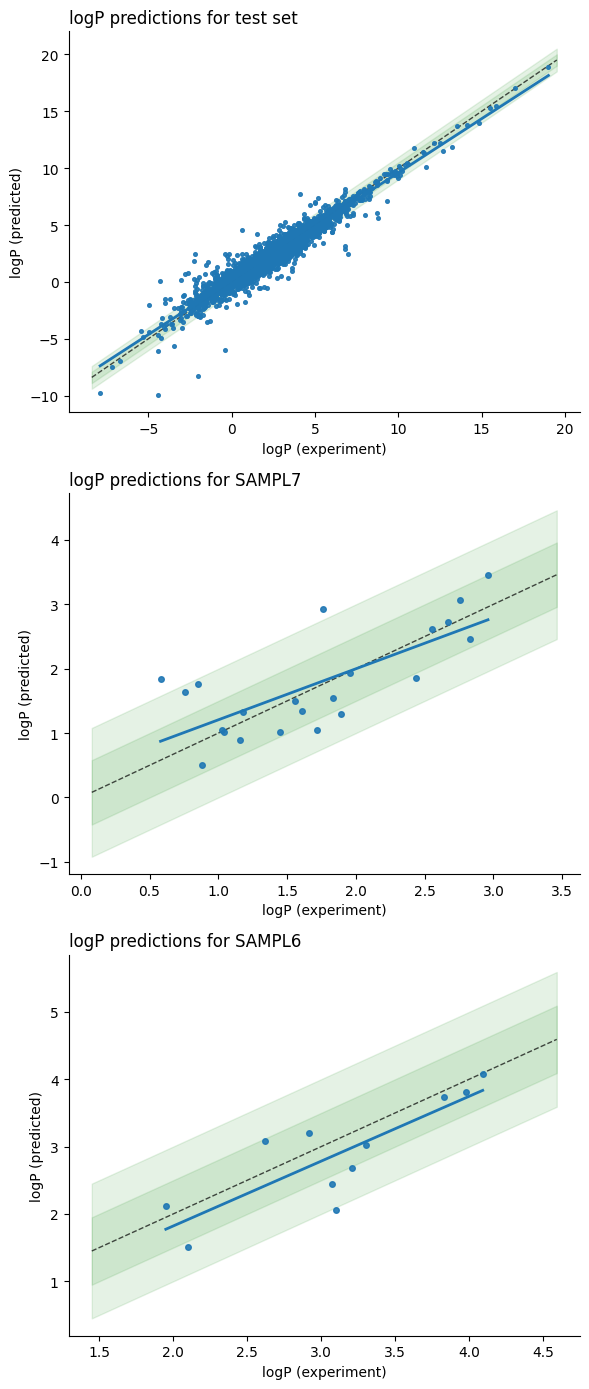

In [34]:
# Compute metrics and CI by bootstrap

pd.options.display.float_format = '{:,.2f}'.format

# experimental uncertainties for SAMPL
SAMPL7_exp_uncertainty = np.array(
    [0.01]*4 + [0.03]*6 + [0.02]*5 + [0.05, 0.01, 0.03, 0.01, 0.03, 0.04, 0.01]
)

SAMPL6_exp_uncertainty = np.array(
    [0.03]*2 + [0.04, 0.03, 0.07, 0.04, 0.03, 0.04, 0.03, 0.03, 0.01, 0.01]
)

# set figure for plotting
fig, ax = plt.subplots(3, 1, figsize=(6, 14))

# marker sizes for scatter plot
msizes = [7, 16, 16]

# set experimental uncertainties if known
exp_uncert = [None, 
              SAMPL7_exp_uncertainty, 
              SAMPL6_exp_uncertainty]

# choose test datasets
test_datasets = [dataset_te, 
                 logP(choose_file="SAMPL7.sdf"), 
                 logP(choose_file="SAMPL6.sdf")] 

dataset_names = ['test set', 'SAMPL7', 'SAMPL6']

# bootstrap sample sizes
sample_sizes = [50, 22, 16] 

# nr of steps for bootstrap, 10000 as in SAMPL7 challange
steps = 10000

# perform analysis
results = []
for i, ds in enumerate(test_datasets):
    
    # load test data and make predictions for the whole dataset
    preds, Y, datalen = load_data_and_predict(ds)
    
    # perform bootstrap
    r = bootstrap(
        preds, Y, datalen, steps=steps, 
        sample_size=sample_sizes[i], exp_uncert=exp_uncert[i]
    )
    # compute metrcis and CI
    df = compute_bootstrap_statistics(r)
    df.rmse = rmse(preds, Y)
    df.mae = mae(preds, Y)
    df.r2 = r2(preds, Y)
    df.kendall = kendall_tau(preds, Y)
    
    # plot results and lin. regression lines (blue)
    plot_test(ax[i], preds, Y, dataset_names[i], msizes[i])
    plt.tight_layout()
    
    results.append(df)

    
    
df = pd.concat(results)    
df.index = dataset_names
df

In [35]:
fig.savefig('logP_predictions.png')